In [25]:
# Works based on https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# Preprocessing based on https://github.com/TegarSU/Topic-Modelling/blob/master/Preprocessing.ipynb
import pandas as pd
import numpy as np
import json
import os
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models import Phrases
import pyLDAvis
import pyLDAvis.gensim
from random import randint
import ast
import logging

In [26]:
df = pd.read_csv(os.path.join(os.pardir,os.pardir,'data','05_out','2-KCore-tweet-clean.csv'))

In [27]:
df.head()

,text,username,modularity,node_id,clean
0,Mereka itu korban yg kalah di 2014. Inget siap...,b12_7hon,4,0,"['korban', 'kalah', 'loloskan', 'pemilu', 'ren..."
1,Penomena @KPU_RI @KPU_ID tdk kuat scra lembaga...,harun_nugraha,4,1,"['fenomena', 'kuat', 'lembaga', 'laksana', 'ba..."
2,ngapain pemilu ulang broo klu kita 02 sdh mena...,totonaser11,5,3,"['pemilu', 'ulang', 'broo', 'menang', 'jokowi'..."
3,"Kl menerapkan ISO pasti kelar 1 minggu, ngga a...",rohmatjabbar,5,5,"['terap', 'selesai', 'minggu', 'korban', 'romu..."
4,Hayooo @KPU_ID @bawaslu_RI simak baik2 orasi k...,use_will,3,6,"['ayo', 'simak', 'orasi', 'ketua', 'tugas', 'a..."


In [28]:
clean = df['clean']

In [29]:
clean.head()

0    ['korban', 'kalah', 'loloskan', 'pemilu', 'ren...
1    ['fenomena', 'kuat', 'lembaga', 'laksana', 'ba...
2    ['pemilu', 'ulang', 'broo', 'menang', 'jokowi'...
3    ['terap', 'selesai', 'minggu', 'korban', 'romu...
4    ['ayo', 'simak', 'orasi', 'ketua', 'tugas', 'a...
Name: clean, dtype: object

In [30]:
clean = list(map(ast.literal_eval,clean))

## Create Bigram

In [31]:
#https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
bigram = Phrases(clean, min_count=10)
for idx in range(len(clean)):
    for token in bigram[clean[idx]]:
        if '_' in token:
            #Token is a bigram, add to document.
            clean[idx].append(token)

In [32]:
for i in range(100, 110):
    print(bigram[clean][i])

['rapat_pleno', 'buka', 'rekapitulasi_hasil', 'hitung_suara', 'pemilu', 'tingkat', 'kota_malang', 'april', 'kpu_jatim', 'rapat_pleno', 'rekapitulasi_hasil', 'hitung_suara', 'kota_malang', 'kpu_jatim']
['ilmu', 'undang', 'larang', 'orang', 'rumus', 'dimana', 'dilarang', 'manipulasi', 'suara', 'pemilu', 'giring_opini', 'hak', 'diakui', 'undang', 'fungsi', 'lembaga_survey', 'dominan', 'pd', 'framing', 'bentuk', 'opini', 'bahaya', 'giring_opini', 'lembaga_survey']
['asumsi', 'survey', 'digaungkan', 'masif', 'dianggap', 'bahaya', 'hasil', 'pemilu', 'launching', 'hasil', 'qc', 'dinyatakan', 'menang', 'pemilu', 'timbul', 'simpul', 'hasil', 'qc', 'qc', 'ditayangan', 'simpul', 'surveyornya']
['situng', 'kpu', 'orang', 'akses', 'dimanapun', 'bukti', 'pemilu', 'transparan', 'indonesia', 'negara', 'hukum', 'laporkan', 'kecuranagan', 'pemungutan_hitung', 'suara', 'kpu', 'kerja_keras', 'pemungutan_hitung', 'kerja_keras']
['sandiaga', 'tidak_memberi', 'pengaruh', 'hadap', 'elektabilitas', 'pemilu', '

# LDA

In [33]:
# Logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Build Bag Of Words Corpus Dictionary

In [34]:
dictionary = gensim.corpora.Dictionary(clean)

In [35]:
# Preview
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 kalah
1 korban
2 loloskan
3 pemilu
4 rentak
5 aneka


## Filter token

In [36]:
dictionary.filter_extremes()

## Build BoW Corpus

In [37]:
bow_corpus = [dictionary.doc2bow(doc) for doc in clean]

#### Corpus Preview

In [38]:
def bow_corpus_sample(corpus, random_index):
    sample = corpus[random_index]
    print('Corpus sample index : ',random_index)
    for i in range(len(sample)):
        print("Word {} (\"{}\") appears {} time.".format(sample[i][0], 
                                                         dictionary[sample[i][0]], 
                                                         sample[i][1]))

In [39]:
sample_index = randint(0,10000)
bow_corpus_sample(bow_corpus, sample_index)

Corpus sample index :  2700
Word 1 ("korban") appears 1 time.
Word 17 ("amanah") appears 1 time.
Word 23 ("kpu") appears 1 time.
Word 58 ("indonesia") appears 1 time.
Word 87 ("makan") appears 1 time.
Word 88 ("makan_korban") appears 1 time.
Word 95 ("data") appears 1 time.
Word 140 ("anggota") appears 1 time.
Word 177 ("ratus") appears 1 time.
Word 421 ("anggota_kpps") appears 1 time.
Word 426 ("kpps") appears 1 time.
Word 474 ("tidak_percaya") appears 2 time.
Word 511 ("jiwa") appears 1 time.
Word 1048 ("bobrok") appears 1 time.
Word 1135 ("menginput") appears 1 time.
Word 1136 ("menginput_data") appears 1 time.
Word 1212 ("jaga") appears 1 time.
Word 2236 ("slalu") appears 1 time.


## Find model with optimal Number Of Topics
https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [52]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=clean, start=2, limit=11, step=2)

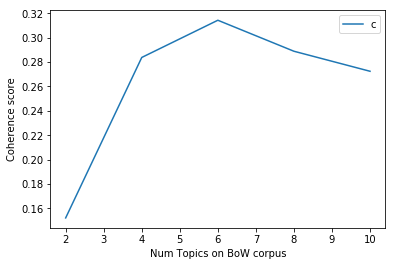

In [56]:
# Show graph
limit=11; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics on BoW corpus")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"))
plt.show()
# plt.savefig(os.path.join(os.pardir,os.pardir,'data','06_out','2-KCore_model','2-KCore_ldamodel'),dpi=300)

# Feed best number of topics

In [57]:
coherence_values

[0.15201180484776872,
 0.28384345812969963,
 0.31441345288639255,
 0.2889425162167071,
 0.27249218073910353]

In [58]:
# Please check best model (model with highest coherence score)
lda_model = model_list[2]

In [59]:
print(lda_model)

LdaModel(num_terms=5062, num_topics=6, decay=0.5, chunksize=2000)


## Save Best Model

In [60]:
lda_model.save(os.path.join(os.pardir,os.pardir,'data','06_out','2-KCore_model','ldamodel'))

## Load Model

In [ ]:
# lda_model = LdaModel.load(os.path.join('data','06_out','2-KCore_model','ldamodel'), mmap='r')
# print(lda_model)

In [61]:
# Show Topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"curang" + 0.014*"allah" + 0.010*"orang" + 0.009*"kpu" + 0.009*"moga" + 0.009*"rakyat" + 0.008*"kpps" + 0.008*"pilih" + 0.008*"ketua" + 0.007*"adil"
Topic: 1 
Words: 0.054*"kpu" + 0.012*"selenggara" + 0.011*"jakarta" + 0.009*"hasil" + 0.009*"buka" + 0.009*"kota" + 0.009*"rabu" + 0.008*"lpsdk" + 0.008*"serah" + 0.008*"resmi"
Topic: 2 
Words: 0.041*"suara" + 0.022*"surat" + 0.021*"misi" + 0.020*"visi" + 0.018*"surat_suara" + 0.017*"visi_misi" + 0.015*"selenggara" + 0.014*"kotak" + 0.012*"pilih" + 0.010*"rakyat"
Topic: 3 
Words: 0.025*"rakyat" + 0.024*"adil" + 0.023*"jujur" + 0.018*"selenggara" + 0.016*"jujur_adil" + 0.016*"curang" + 0.015*"kpu" + 0.013*"negara" + 0.012*"uang" + 0.011*"salah"
Topic: 4 
Words: 0.029*"kpu" + 0.015*"calon" + 0.014*"presiden" + 0.012*"pasang" + 0.012*"debat" + 0.011*"rakyat" + 0.010*"adil" + 0.010*"hasil" + 0.010*"capres" + 0.010*"selenggara"
Topic: 5 
Words: 0.031*"kpu" + 0.023*"undang" + 0.018*"pilih" + 0.012*"orang" + 0.012*"rakyat" 

## Visualization

In [62]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.098578  0.073993       1        1  24.618372
4     -0.044089 -0.008499       2        1  18.461872
0     -0.074922  0.011656       3        1  16.888294
5      0.000706  0.008482       4        1  14.315483
2      0.172368  0.090717       5        1  13.159617
1      0.044514 -0.176349       6        1  12.556359, topic_info=     Category         Freq          Term        Total  loglift  logprob
146   Default  2025.000000         suara  2025.000000  30.0000  30.0000
23    Default  5269.000000           kpu  5269.000000  29.0000  29.0000
1303  Default   729.000000         surat   729.000000  28.0000  28.0000
4280  Default   670.000000          misi   670.000000  27.0000  27.0000
4281  Default   698.000000          visi   698.000000  26.0000  26.0000
1304  Default   573.000000   surat_suara   573.000000  25.0000  25.0000
131   Default  1048.000000        undang  1048.000000  24.0000  24.0000
4282  Default   526.000000     visi_misi   526.000000  23.0000  23.0000
1534  Default   492.000000         kotak   492.000000  22.0000  22.0000
74    Default  2198.000000          adil  2198.000000  21.0000  21.0000
377   Default   648.000000         allah   648.000000  20.0000  20.0000
34    Default  2624.000000        curang  2624.000000  19.0000  19.0000
77    Default  2096.000000         jujur  2096.000000  18.0000  18.0000
78    Default  1357.000000    jujur_adil  1357.000000  17.0000  17.0000
1108  Default   441.000000       jakarta   441.000000  16.0000  16.0000
302   Default  1052.000000         calon  1052.000000  15.0000  15.0000
1388  Default   389.000000        kardus   389.000000  14.0000  14.0000
1618  Default   303.000000   kotak_suara   303.000000  13.0000  13.0000
100   Default  1864.000000         pilih  1864.000000  12.0000  12.0000
51    Default   757.000000        pasang   757.000000  11.0000  11.0000
178   Default   567.000000           hak   567.000000  10.0000  10.0000
173   Default   813.000000          uang   813.000000   9.0000   9.0000
2586  Default   333.000000          rabu   333.000000   8.0000   8.0000
187   Default   358.000000          kota   358.000000   7.0000   7.0000
5056  Default   332.000000         lpsdk   332.000000   6.0000   6.0000
309   Default   529.000000  pasang_calon   529.000000   5.0000   5.0000
520   Default   413.000000          buka   413.000000   4.0000   4.0000
2204  Default   886.000000         debat   886.000000   3.0000   3.0000
148   Default   960.000000      presiden   960.000000   2.0000   2.0000
13    Default  1457.000000         orang  1457.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
3685   Topic6    48.882580   tidak_dapat    55.847023   1.9417  -6.3759
527    Topic6   211.769684         rapat   262.049713   1.8619  -4.9098
1621   Topic6    55.592381          ppln    64.160721   1.9316  -6.2473
1108   Topic6   327.654846       jakarta   441.956238   1.7757  -4.4733
2586   Topic6   246.089706          rabu   333.117188   1.7721  -4.7596
187    Topic6   255.623016          kota   358.429352   1.7369  -4.7216
311    Topic6   216.038422         serah   305.087769   1.7298  -4.8898
416    Topic6   170.661453           wib   236.264816   1.7497  -5.1256
155    Topic6   178.971451      provinsi   249.291626   1.7435  -5.0781
412    Topic6   215.566772         resmi   320.443237   1.6785  -4.8920
5056   Topic6   219.978043         lpsdk   332.735168   1.6611  -4.8718
520    Topic6   260.088196          buka   413.337433   1.6117  -4.7043
2762   Topic6    68.252686      aplikasi    88.349594   1.8169  -6.0421
185    Topic6   183.422241     kabupaten   326.261108   1.4990  -5.0535
23     Topic6  1553.687500           kpu  5269.536133   0.8536  -2.9169
813    Topic6    71.081581        jelang   100.111923   1.7325  -6.0015
281    Topic6   200.741898       bawaslu   470.581726   1.2230  -4.96

# Classify Document to Topic

In [65]:
sample_index = randint(0,10000)
bow_corpus_sample(bow_corpus, sample_index)

Corpus sample index :  9286
Word 34 ("curang") appears 1 time.
Word 50 ("habis") appears 1 time.
Word 326 ("lawan") appears 1 time.


In [66]:
# Mencari probabilitas tertinggi topik untuk dokumen
for index, score in sorted(lda_model[bow_corpus[sample_index]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.790356457233429	 
Topic: 0.025*"rakyat" + 0.024*"adil" + 0.023*"jujur" + 0.018*"selenggara" + 0.016*"jujur_adil" + 0.016*"curang" + 0.015*"kpu" + 0.013*"negara" + 0.012*"uang" + 0.011*"salah"

Score: 0.04222416505217552	 
Topic: 0.028*"curang" + 0.014*"allah" + 0.010*"orang" + 0.009*"kpu" + 0.009*"moga" + 0.009*"rakyat" + 0.008*"kpps" + 0.008*"pilih" + 0.008*"ketua" + 0.007*"adil"

Score: 0.041904907673597336	 
Topic: 0.031*"kpu" + 0.023*"undang" + 0.018*"pilih" + 0.012*"orang" + 0.012*"rakyat" + 0.011*"hak" + 0.011*"suara" + 0.007*"hasil" + 0.007*"menang" + 0.007*"kali"

Score: 0.04189758747816086	 
Topic: 0.029*"kpu" + 0.015*"calon" + 0.014*"presiden" + 0.012*"pasang" + 0.012*"debat" + 0.011*"rakyat" + 0.010*"adil" + 0.010*"hasil" + 0.010*"capres" + 0.010*"selenggara"

Score: 0.04185284301638603	 
Topic: 0.041*"suara" + 0.022*"surat" + 0.021*"misi" + 0.020*"visi" + 0.018*"surat_suara" + 0.017*"visi_misi" + 0.015*"selenggara" + 0.014*"kotak" + 0.012*"pilih" + 0.010*"rakyat"


In [67]:
# Buat list probabilitas tertinggi topik untuk semua dokumen
topic_list = []
for i in range(len(bow_corpus)):
    sorted_probability = sorted(lda_model.get_document_topics(bow_corpus[i]), key = lambda x: x[1], reverse=True)
    topic_list.append(sorted_probability[0][0])

In [68]:
df['topic'] = topic_list

In [69]:
df.tail(10)

,text,username,modularity,node_id,clean,topic
20707,Pertama nih di 2019!! Mumpung masih anget! Apa...,_pemilihpemula,4,12271,"['mumpung', 'hangat', 'pemilu', 'admin', 'kasi...",2
20708,Mending pemilu ditunda smpai jokowi siapp..,abaz009,5,13209,"['mending', 'pemilu', 'tunda', 'jokowi']",5
20709,Maka dari itu aneh bener dah pemilu skrang rus...,koerniad1,5,13210,"['aneh', 'pemilu', 'rusak', 'tatanan', 'demokr...",3
20710,Kok @KPU_ID jadi ngga kredibel gini...?. Semua...,binarmentari_ok,3,4809,"['kredibel', 'perilaku', 'nonton', 'nasional',...",3
20711,Mereka tu dah sadar kalah dalam segala hal dan...,fakirelmu,5,13211,"['sadar', 'kalah', 'proses', 'pemilu', 'menang...",5
20712,Yang namanya sumpah dan janji sdh tak berharga...,uman_2009,3,11498,"['nama', 'sumpah', 'janji', 'harga', 'rezim', ...",4
20713,Mana ada wasit terserah Pemain . Wasit itu mem...,prabow0fans,3,5526,"['wasit', 'serah', 'main', 'wasit', 'pimpin', ...",3
20714,berarti bukan kampanye .. lihat di UU ttg pemi...,pendekarmalu,4,13212,"['arti', 'kampanye', 'lihat', 'undang', 'pemil...",0
20715,Diskusi akhir tahun kemarin dan sempat bahas m...,jamalboegis,0,851,"['diskusi', 'kemarin', 'bahas', 'kotak', 'kard...",2
20716,bener kata ibu prof mantan komisioner @KPU_ID ...,sameercimy_,5,199,"['profesor', 'mantan', 'komisioner', 'lupa', '...",0


In [70]:
# Export to csv
df.to_csv(os.path.join(os.pardir,os.pardir,'data','06_out','2-KCore-tweet-clean-topic.csv'), index=False)